### Instructor Demo: Financial Forecasting Part II

This program executes `1000` simulations of stock price trajectory over the next `252 * 3` trading days (or 3 years of trading) for `TSLA` stock, based on a normal probability distribution of average daily returns derived from the sample mean and standard deviation. Then, the program calculates a `95%` confidence interval of stock price outcomes for `TSLA`. 

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Assets
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': '2a5db6a2-c035-46cc-840f-fa519740a9b5',
     'marginable': True,
     'name': 'LifeSci Acquisition Corp. Common Stock',
     'shortable': False,
     'status': 'active',
     'symbol': 'LSAC',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'NYSE',
     'id': '49b90cdc-f6f5-4a7c-807a-ed172e6017af',
     'marginable': True,
     'name': 'American Express Company',
     'shortable': True,
     'status': 'active',
     'symbol': 'AXP',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'NYSE',
     'id': 'f85c0ede-3556-4d0b-9e0c-4ffc2425044d',
     'marginable': True,
     'name': 'Diageo plc',
     'shortable': True,
     'status': 'active',
     'symbol': 'DEO',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NYSE',
     'i

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,LSAC
1,AXP
2,OIL
3,CCA
4,CY
5,NFO
6,CBPX
7,GRSH_DELISTED
8,N014776_DELISTED
9,KOR


### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [5]:
# Set the ticker
ticker = "TSLA"

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Format end_date and start_date with isoformat
end_date = pd.Timestamp(end_date, tz="America/New_York").isoformat()
start_date = pd.Timestamp(start_date, tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for TSLA
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

TSLA                                     
                             open     high       low   close    volume
2019-05-07 00:00:00-04:00  256.80  257.210  245.1000  247.06   9542822
2019-05-08 00:00:00-04:00  246.94  250.599  244.2000  244.76   5757805
2019-05-09 00:00:00-04:00  242.00  243.680  236.9434  241.98   6455536
2019-05-10 00:00:00-04:00  239.75  241.990  236.0200  239.51   6716345
2019-05-13 00:00:00-04:00  232.01  232.470  224.5000  227.01  10159046

### Drop Extraneous Columns

In [6]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.head()

,close
2019-05-07,247.06
2019-05-08,244.76
2019-05-09,241.98
2019-05-10,239.51
2019-05-13,227.01


### Calculate Daily Returns

In [7]:
# Use the `pct_change` function to calculate daily returns of TSLA
daily_returns = df.pct_change()
daily_returns.head()

,close
2019-05-07,NaN
2019-05-08,-0.009309
2019-05-09,-0.011358
2019-05-10,-0.010207
2019-05-13,-0.052190


### Calculate Value of Average Daily Returns

In [8]:
# Use the `mean` function to calculate the mean of daily returns for TSLA
avg_daily_return = daily_returns.mean()['close']
avg_daily_return

0.005764320559715032

### Calculate Value of Standard Deviation of Daily Returns

In [9]:
# Use the `std` function to calculate the standard deviation of daily returns for TSLA
std_dev_daily_return = daily_returns.std()['close']
std_dev_daily_return

0.04863183163111945

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [10]:
# Set number of simulations, trading days, and get last closing price of TSLA from DataFrame
num_simulations = 1000
num_trading_days = 252 * 3
tsla_last_price = df['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of TSLA
    simulated_tsla_prices = [tsla_last_price]
    
    # Simulate the returns for 252 * 3 days
    for i in range(num_trading_days):
        # Calculate the simulated price using the last price within the list
        simulated_price = simulated_tsla_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
        # Append the simulated price to the list
        simulated_tsla_prices.append(simulated_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df[f"Simulation {n+1}"] = pd.Series(simulated_tsla_prices)

# Print head of DataFrame
simulated_price_df.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,782.450000,782.450000,782.450000,782.450000,782.450000,782.450000,782.450000,782.450000,782.450000,782.450000,...,782.450000,782.450000,782.450000,782.450000,782.450000,782.450000,782.450000,782.450000,782.450000,782.450000
1,788.303953,777.381792,824.025524,838.894354,695.829990,823.054056,724.572816,798.234186,837.550871,739.569810,...,780.146497,750.881847,725.757726,761.519908,820.208252,780.583109,734.953346,801.905569,813.722644,813.985672
2,839.713136,787.329032,761.104694,886.601651,662.212383,885.970811,768.224476,811.936009,870.854000,755.701883,...,793.100764,741.202836,736.034838,787.940532,789.510691,779.712625,707.762129,798.306736,854.934610,822.943150
3,820.476982,747.196779,739.116030,828.447242,669.574670,900.228095,810.314140,775.080560,881.147875,750.405766,...,747.730367,686.210034,781.439759,851.065362,779.766223,732.043306,688.138200,808.601050,887.820738,790.029602
4,867.771251,773.667339,738.555980,796.374543,615.109013,892.410708,915.443915,800.721414,918.871980,819.383939,...,734.677130,670.555408,712.143821,818.484722,770.751898,734.223506,666.943875,788.647324,866.471077,753.884750


### Plot the Multiple Simulations of Stock Price Trajectory for TSLA over the Next 3 Years (252 * 3 Trading Days)

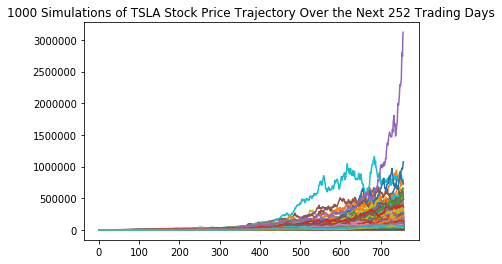

In [11]:
# Use the `plot` function to plot the trajectory of TSLA stock based on a 252 * 3 trading day simulation
plot_title = f"{n+1} Simulations of TSLA Stock Price Trajectory Over the Next 252 Trading Days"
simulated_price_df.plot(legend=None, title=plot_title)

In [12]:
# Select the last row for projecting stock prices (prices of each simulation on the last simulated trading day)
simulated_ending_prices = simulated_price_df.iloc[-1, :]
simulated_ending_prices.head()

Simulation 1    42800.528774
Simulation 2    22461.301448
Simulation 3    11575.655946
Simulation 4     5513.058607
Simulation 5    19269.878276
Name: 756, dtype: float64

### Plot the Frequency Distribution of Simulated Ending Prices on the Last Simulated Trading Day

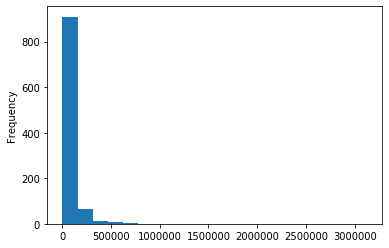

In [13]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
simulated_ending_prices.plot(kind='hist', bins=20)

### View the Probability Distribution of Simulated Ending Price Ranges on the Last Simualted Trading Day

In [14]:
# Use the `value_counts` function to create the frequency distribution and 
# sort the data into 20 bins. Divide the value counts of each bin by the total
# number of prices to return the probability of each range
simulated_ending_prices.value_counts(bins=20) / len(simulated_ending_prices)

(-2819.6220000000003, 156411.941]    0.909
(156411.941, 312521.316]             0.063
(312521.316, 468630.69]              0.012
(468630.69, 624740.065]              0.009
(624740.065, 780849.439]             0.005
(936958.814, 1093068.188]            0.001
(2966380.682, 3122490.057]           0.001
(1873615.061, 2029724.435]           0.000
(1717505.686, 1873615.061]           0.000
(1561396.312, 1717505.686]           0.000
(2810271.308, 2966380.682]           0.000
(1249177.563, 1405286.937]           0.000
(1093068.188, 1249177.563]           0.000
(2029724.435, 2185833.81]            0.000
(780849.439, 936958.814]             0.000
(2185833.81, 2341943.184]            0.000
(2341943.184, 2498052.559]           0.000
(2498052.559, 2654161.933]           0.000
(2654161.933, 2810271.308]           0.000
(1405286.937, 1561396.312]           0.000
Name: 756, dtype: float64

### Calculate Lower and Upper Bounds of 95% Confidence Interval for Simulated Ending Stock Prices of TSLA

In [15]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices.quantile(q=[0.025, 0.975])
confidence_interval

0.025      1731.874003
0.975    349754.132436
Name: 756, dtype: float64

### Plot the Probability Distribution and 95% Confidence Interval of Simulated Ending Prices 

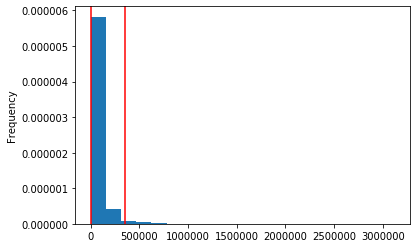

In [16]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
simulated_ending_prices.plot(kind='hist', density=True, bins=20)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

### Calculate 95% Confidence Interval of An Initial Investment of 10,000 in TSLA over the Next 3 Years (252 * 3) Trading Days

In [17]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - tsla_last_price) / tsla_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - tsla_last_price) / tsla_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in TSLA"
      f" over the next (252 * 3) trading days will end within in the range of"
      f" ${ending_investment_lower_bound} and ${ending_investment_upper_bound}")

There is a 95% chance that an initial investment of $10,000 in TSLA over the next (252 * 3) trading days will end within in the range of $22133.989434227813 and $4469986.995159543
